In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [28]:
class One_Hidden_Layer_Model:
    def __init__(self,X,Y,nx,nh,ny,hidden_function="tanh",output_function="sigmoid",epochs=100000,
            learning_mode="batch",learning_rate_mode="constant",learning_rate_update_ratio=1-(1e-4),learning_rate=0.01,
            convergence_rate=1e-8 , convergence_iteration = 100):

        # input data
        self.X = np.array(X)
        # real output
        self.Y = np.array(Y)
        # input layer size. +1 for augmentation
        self.nx = nx +1
        # hidden layer size
        self.nh = nh
        # output layer size
        self.ny = ny
        # rate of update weights in first and second weight matrix
        self.learning_rate1 = learning_rate
        self.learning_rate2 = learning_rate
        # ratio of updating learning rate
        self.learning_rate_update_ratio = learning_rate_update_ratio
        # rate of convergence
        self.convergence_rate = convergence_rate
        # iteration of convergence
        self.convergence_iteration = convergence_iteration
        # maximum number of epochs
        self.epochs = epochs
        # Errors
        self.errors = []

        # Weights
        self.W1 = self.Weight_init(self.nh,self.nx)
        self.W2 = self.Weight_init(self.ny,self.nh+1)

        # set hidden layer activation function throw hidden_function parameter
        # check input validation 
        if(hidden_function != "tanh" and hidden_function != "sigmoid"):
            raise ValueError("invalid value for hidden_function")
        self.hidden_function = self.tanh if(hidden_function == "tanh") else self.sigmoid 
        self.df1 = self.d_tanh if(hidden_function == "tanh") else self.d_sigmoid

        # set output layer activation function throw output_function parameter 
        # check input validation
        if(output_function != "tanh" and output_function != "sigmoid" and output_function != "linear"):
            raise ValueError("invalid value for output_function")
        self.output_function = self.tanh if(output_function == "tanh") else self.sigmoid if(output_function == "sigmoid") else self.linear
        self.threshold = 0 if(output_function == "tanh") else 0.5
        self.df2 = self.d_tanh if(output_function == "tanh") else self.d_sigmoid if(output_function == "sigmoid") else self.d_linear

        if(output_function == "tanh"):
          self.Y[self.Y == 0] = -1
          self.classes = [-1,1]
        else:
          self.classes = [0,1]

        # set learning mode ( batch or online )
        # check input validation
        if(learning_mode != "batch" and learning_mode != "online"):
            raise ValueError("invalid value for learning_mode")
        self.train = self.batch if(learning_mode == "batch") else self.online

        # set learning rate mode ( constant or dynamic )
        # check input validation
        if(learning_rate_mode != "constant" and learning_rate_mode != "dynamic"):
            raise ValueError("invalid value for learning_rate_mode")
        self.learning_rate_update = self.dynamic_learning_rate if(learning_rate_mode == "dynamic") else self.constant_learning_rate


        # test data and network size
        assert(self.nx == self.X.shape[1]+1)
        assert(self.ny == self.Y.shape[1])
        assert(self.X.shape[0] == self.Y.shape[0])

    def split_train_test_data(self,train_rate = 0.7):
        Data = np.hstack((self.X ,self.Y))
        
        Data0 = Data[np.where(Data[:,-1]==self.classes[0])]
        Data1 = Data[np.where(Data[:,-1]==self.classes[1])]

        train_size0 = int(train_rate*Data0.shape[0])
        train_size1 = int(train_rate*Data1.shape[0])

        train_data = np.concatenate((Data0[0:train_size0,:],Data1[0:train_size1,:]))
        np.random.shuffle(train_data)
        test_data  = np.concatenate((Data0[train_size0:,:],Data1[train_size1:,:]))
        
        self.X_train = self.augmentation(train_data[:,0:self.X.shape[1]])
        self.X_test  = self.augmentation(test_data[:,0:self.X.shape[1]])
        self.Y_train = train_data[:,self.X.shape[1]:]
        self.Y_test  = test_data[:,self.X.shape[1]:]
    
    def augmentation(self,data):
        one = np.ones((data.shape[0],1))
        aug_data = np.hstack((data,one))
        return aug_data
    
    def sigmoid(self,inp):
        return 1/(1+np.exp(-inp))
    
    def d_sigmoid(self,y_hat):
        return np.multiply(y_hat,1-y_hat)

    def tanh(self,inp):
        return np.tanh(inp)
    
    def d_tanh(self,y_hat):
        return 1 - np.square(y_hat)
    
    def linear(self,inp):
        return inp

    def d_linear(self,y_hat):
        return np.ones(y_hat.shape)

    def MSE(self,Y,Y_hat):
        return np.square(np.subtract(Y,Y_hat)).mean()

    def Weight_init(self,n,m,rate=0.1):
        np.random.seed(0)
        weights = rate * np.random.uniform(-1, 1, n*m)
        weights = weights.reshape((n,m))
        return weights

    def train_accuracy(self, a , b):
        return 100*(np.sum(np.abs(np.subtract(a,b)) < 0.1)/a.shape[0])

    def accuracy(self):
        A1 = np.dot(self.X_test,self.W1.T)
        Z1 = self.hidden_function(A1)
        Z1_aug = self.augmentation(Z1)
        A2 = np.dot(Z1_aug,self.W2.T)
        Z2 = self.output_function(A2) 
        return 100*(np.sum(np.abs(np.subtract(self.Y_test,Z2)) < (np.abs(self.classes[0])+np.abs(self.classes[1]))/2)/Z2.shape[0])

    def constant_learning_rate(self):
        pass

    def dynamic_learning_rate(self):
        self.learning_rate1 *= self.learning_rate_update_ratio
        self.learning_rate2 *= self.learning_rate_update_ratio

    def plot_mse(self):
        plt.xlabel("epochs")
        plt.ylabel("MSE")
        plt.scatter([i+1 for i in range(len(self.errors))],self.errors,s=10)

    def plot_decision_boundary(self):
        x_min, x_max = self.X[:,0].min() - 1, self.X[:,0].max() + 1
        y_min, y_max = self.X[:,1].min() - 1, self.X[:,1].max() + 1
        h = 0.01
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        data = np.c_[xx.ravel(), yy.ravel()]
        data = self.augmentation(data)
        A1 = np.dot(data,self.W1.T)
        Z1 = self.hidden_function(A1)
        Z1_aug = self.augmentation(Z1)
        A2 = np.dot(Z1_aug,self.W2.T)
        Z2 = self.output_function(A2)
        Z = Z2.reshape(xx.shape) > self.threshold
        plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
        plt.ylabel('x2')
        plt.xlabel('x1')
        plt.scatter(self.X[:,0], self.X[:,1], c=self.Y , s=5, cmap='binary')

    def batch(self):
        for i in range(self.epochs):
            A1 = np.dot(self.X_train,self.W1.T)
            Z1 = self.hidden_function(A1)
            Z1_aug = self.augmentation(Z1)
            A2 = np.dot(Z1_aug,self.W2.T)
            Z2 = self.output_function(A2)
            mse = self.MSE(self.Y_train,Z2)
            e = (self.Y_train - Z2)
            dw2 = self.learning_rate2 * np.dot(np.multiply(e,self.df2(Z2)).T,Z1_aug)
            w2 = self.W2[:,:-1]
            a = np.multiply(e,self.df2(Z2))
            b = np.dot(a,w2)
            c = np.multiply(b,self.df1(Z1))
            d = np.dot(c.T,self.X_train)
            dw1 =  (self.learning_rate1 * d)
            self.W1 += dw1
            self.W2 += dw2
            self.errors.append(mse)
            if(self.train_accuracy(Z2,self.Y_train) > 98):
              break
            if(i >= self.convergence_iteration and 
               np.max(self.errors[-self.convergence_iteration:]) - np.min(self.errors[-self.convergence_iteration:]) < self.convergence_rate):
                break
            self.learning_rate_update()
        self.train_mse = mse
        self.train_accuracy_value = self.train_accuracy(Z2,self.Y_train)

    def online(self):
        for i in range(self.epochs):
            mse = 0
            for j in range(self.X_train.shape[0]):
                x = self.X_train[j].reshape((1,self.nx))
                y = self.Y_train[j].reshape((self.ny,1))
                A1 = np.dot(x,self.W1.T)
                Z1 = self.hidden_function(A1)
                Z1_aug = self.augmentation(Z1)
                A2 = np.dot(Z1_aug,self.W2.T)
                Z2 = self.output_function(A2)
                mse += self.MSE(y,Z2)
                e = ( y - Z2 )
                dw2 = self.learning_rate2 * e *self.df2(Z2) * Z1_aug
                w2 = self.W2[:,:-1]
                a = np.multiply(e,self.df2(Z2))
                b = np.dot(a,w2)
                c = np.multiply(b,self.df1(Z1))
                d = np.dot(c.T,x)
                dw1 =  (self.learning_rate1 * d)
                self.W2 += dw2
                self.W1 += dw1
            self.errors.append(mse/self.X_train.shape[0])
            A1 = np.dot(self.X_train,self.W1.T)
            Z1 = self.hidden_function(A1)
            Z1_aug = self.augmentation(Z1)
            A2 = np.dot(Z1_aug,self.W2.T)
            Z2 = self.output_function(A2)
            if(self.train_accuracy(Z2,self.Y_train) > 98):
              break
            if(i >= self.convergence_iteration and 
               np.max(self.errors[-self.convergence_iteration:]) - np.min(self.errors[-self.convergence_iteration:]) < self.convergence_rate):
                break
            self.learning_rate_update()
            
        self.train_mse = mse
        A1 = np.dot(self.X_train,self.W1.T)
        Z1 = self.hidden_function(A1)
        Z1_aug = self.augmentation(Z1)
        A2 = np.dot(Z1_aug,self.W2.T)
        Z2 = self.output_function(A2)
        self.train_accuracy_value = self.train_accuracy(Z2,self.Y_train)

In [4]:
X , Y = make_moons(n_samples=1000, noise = 0.06)
print(Y.shape,X.shape)

(1000,) (1000, 2)


In [5]:
Y = Y.reshape((Y.shape[0],1))

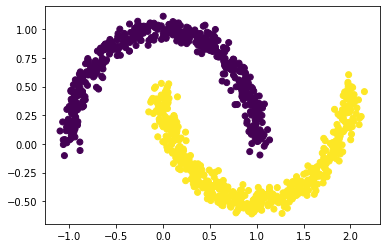

In [6]:
plt.scatter(X[:,0],X[:,1],c=Y)

In [7]:
BCT_Model = One_Hidden_Layer_Model(X,Y,X.shape[1],3,Y.shape[1],learning_mode="batch",
    learning_rate_mode="constant",hidden_function="tanh",output_function="tanh")
BCT_Model.split_train_test_data()
BCT_Model.train()
print("accuracy for test data : %",BCT_Model.accuracy())

accuracy for test data : % 100.0


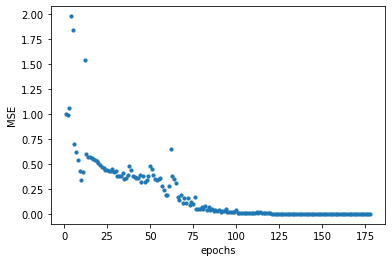

In [8]:
BCT_Model.plot_mse()

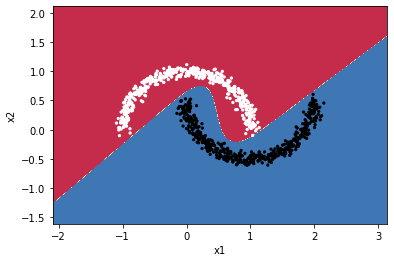

In [9]:
BCT_Model.plot_decision_boundary()

In [10]:
BCS_Model = One_Hidden_Layer_Model(X,Y,X.shape[1],3,Y.shape[1],learning_mode="batch",
    learning_rate_mode="constant",hidden_function="sigmoid",output_function="sigmoid")
BCS_Model.split_train_test_data()
BCS_Model.train()
print("accuracy for test data : %",BCS_Model.accuracy())

accuracy for test data : % 100.0


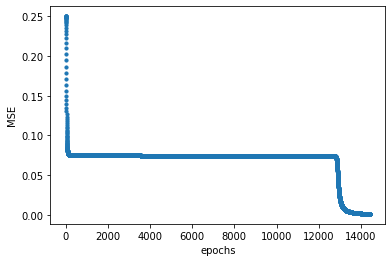

In [11]:
BCS_Model.plot_mse()

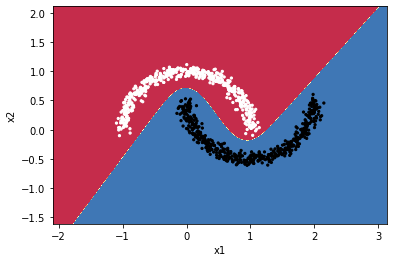

In [12]:
BCS_Model.plot_decision_boundary()

In [13]:
BDT_Model = One_Hidden_Layer_Model(X,Y,X.shape[1],3,Y.shape[1],learning_mode="batch",
    learning_rate_mode="dynamic",hidden_function="tanh",output_function="tanh")
BDT_Model.split_train_test_data()
BDT_Model.train()
print("accuracy for test data : %",BDT_Model.accuracy())

accuracy for test data : % 100.0


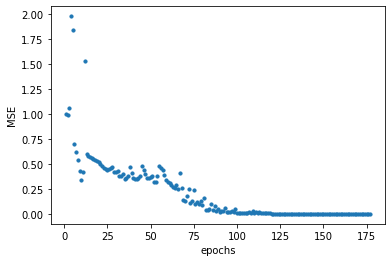

In [14]:
BDT_Model.plot_mse()

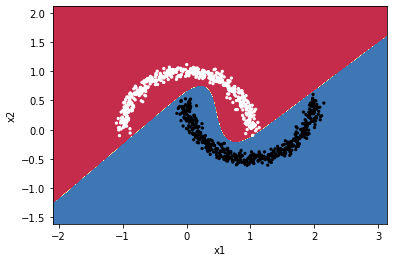

In [15]:
BDT_Model.plot_decision_boundary()

In [35]:
BDS_Model = One_Hidden_Layer_Model(X,Y,X.shape[1],3,Y.shape[1],learning_mode="batch",
    learning_rate_mode="dynamic",hidden_function="sigmoid",output_function="sigmoid")
BDS_Model.split_train_test_data()
BDS_Model.train()
print("accuracy for test data : %",BDS_Model.accuracy())

accuracy for test data : % 86.33333333333333


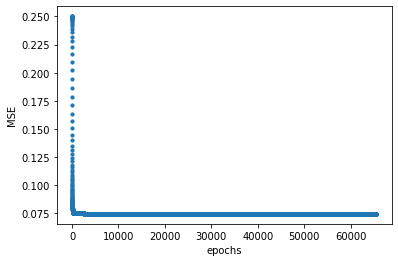

In [36]:
BDS_Model.plot_mse()

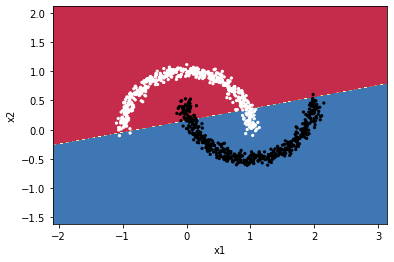

In [37]:
BDS_Model.plot_decision_boundary()

In [106]:
BDS_Model = One_Hidden_Layer_Model(X,Y,X.shape[1],3,Y.shape[1],learning_mode="batch",learning_rate=0.1,
    learning_rate_mode="dynamic",hidden_function="sigmoid",output_function="sigmoid")
BDS_Model.split_train_test_data()
BDS_Model.train()
print("accuracy for test data : %",BDS_Model.accuracy())

accuracy for test data : % 100.0


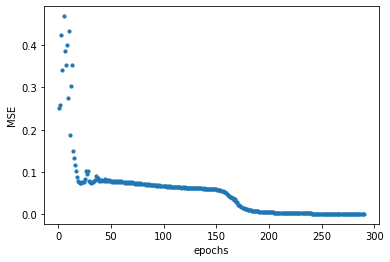

In [107]:
BDS_Model.plot_mse()

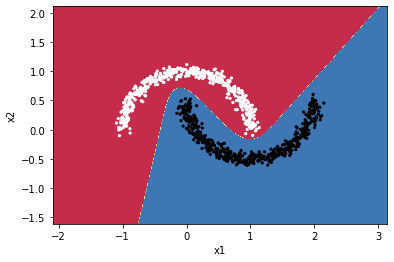

In [108]:
BDS_Model.plot_decision_boundary()

In [38]:
OCT_Model = One_Hidden_Layer_Model(X,Y,X.shape[1],3,Y.shape[1],learning_mode="online",
    learning_rate_mode="constant",hidden_function="tanh",output_function="tanh")
OCT_Model.split_train_test_data()
OCT_Model.train()
print("accuracy for test data : %",OCT_Model.accuracy())

accuracy for test data : % 100.0


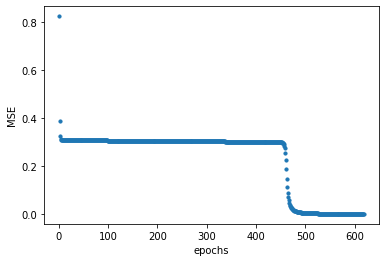

In [39]:
OCT_Model.plot_mse()

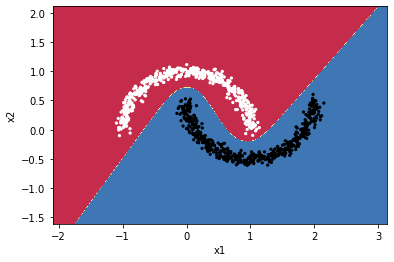

In [40]:
OCT_Model.plot_decision_boundary()

In [41]:
OCS_Model = One_Hidden_Layer_Model(X,Y,X.shape[1],3,Y.shape[1],learning_mode="online",
    learning_rate_mode="constant",hidden_function="sigmoid",output_function="sigmoid")
OCS_Model.split_train_test_data()
OCS_Model.train()
print("accuracy for test data : %",OCS_Model.accuracy())

accuracy for test data : % 100.0


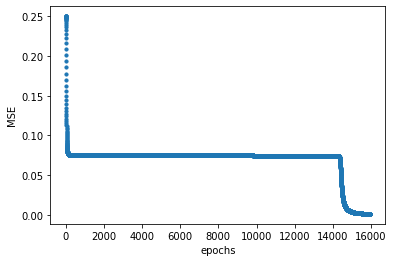

In [42]:
OCS_Model.plot_mse()

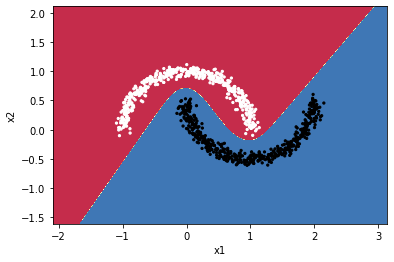

In [43]:
OCS_Model.plot_decision_boundary()

In [44]:
ODT_Model = One_Hidden_Layer_Model(X,Y,X.shape[1],3,Y.shape[1],learning_mode="online",
    learning_rate_mode="dynamic",hidden_function="tanh",output_function="tanh")
ODT_Model.split_train_test_data()
ODT_Model.train()
print("accuracy for test data : %",ODT_Model.accuracy())

accuracy for test data : % 100.0


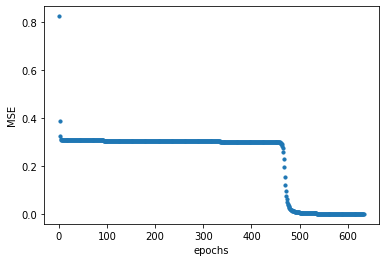

In [45]:
ODT_Model.plot_mse()

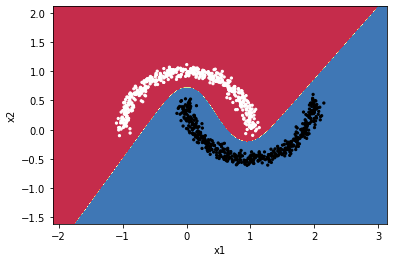

In [46]:
ODT_Model.plot_decision_boundary()

In [99]:
ODS_Model = One_Hidden_Layer_Model(X,Y,X.shape[1],3,Y.shape[1],learning_mode="online",
    learning_rate_mode="dynamic",hidden_function="sigmoid",output_function="sigmoid")
ODS_Model.split_train_test_data()
ODS_Model.train()
print("accuracy for test data : %",ODS_Model.accuracy())

accuracy for test data : % 86.66666666666667


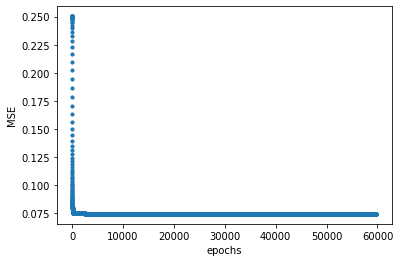

In [100]:
ODS_Model.plot_mse()

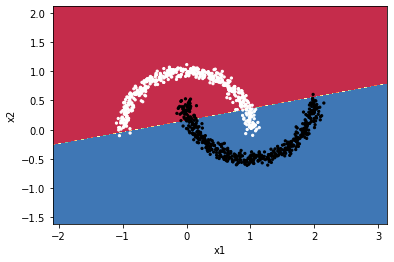

In [101]:
ODS_Model.plot_decision_boundary()

In [103]:
ODS_Model = One_Hidden_Layer_Model(X,Y,X.shape[1],3,Y.shape[1],learning_mode="online",learning_rate=0.1,
    learning_rate_mode="dynamic",hidden_function="sigmoid",output_function="sigmoid")
ODS_Model.split_train_test_data()
ODS_Model.train()
print("accuracy for test data : %",ODS_Model.accuracy())

accuracy for test data : % 100.0


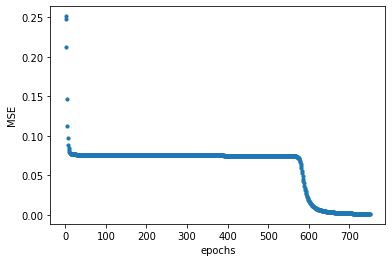

In [104]:
ODS_Model.plot_mse()

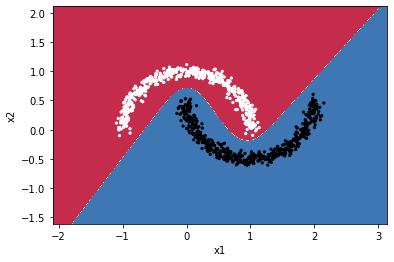

In [105]:
ODS_Model.plot_decision_boundary()

In [95]:
class Momentum_Model:
    def __init__(self,X,Y,nx,nh,ny,hidden_function="tanh",output_function="sigmoid",epochs=100000,
            learning_mode="batch",learning_rate_mode="constant",learning_rate_update_ratio=1-(1e-4),learning_rate=0.01,
            convergence_rate=1e-8 , convergence_iteration = 100,mumentum_ratio=0.9):

        # input data
        self.X = np.array(X)
        # real output
        self.Y = np.array(Y)
        # input layer size. +1 for augmentation
        self.nx = nx +1
        # hidden layer size
        self.nh = nh
        # output layer size
        self.ny = ny
        # rate of update weights in first and second weight matrix
        self.learning_rate1 = learning_rate
        self.learning_rate2 = learning_rate
        # ratio of updating learning rate
        self.learning_rate_update_ratio = learning_rate_update_ratio
        # rate of convergence
        self.convergence_rate = convergence_rate
        # iteration of convergence
        self.convergence_iteration = convergence_iteration
        # maximum number of epochs
        self.epochs = epochs
        # Errors
        self.errors = []

        # Weights
        self.W1 = self.Weight_init(self.nh,self.nx)
        self.W2 = self.Weight_init(self.ny,self.nh+1)

        # set hidden layer activation function throw hidden_function parameter
        # check input validation 
        if(hidden_function != "tanh" and hidden_function != "sigmoid"):
            raise ValueError("invalid value for hidden_function")
        self.hidden_function = self.tanh if(hidden_function == "tanh") else self.sigmoid 
        self.df1 = self.d_tanh if(hidden_function == "tanh") else self.d_sigmoid

        # set output layer activation function throw output_function parameter 
        # check input validation
        if(output_function != "tanh" and output_function != "sigmoid" and output_function != "linear"):
            raise ValueError("invalid value for output_function")
        self.output_function = self.tanh if(output_function == "tanh") else self.sigmoid if(output_function == "sigmoid") else self.linear
        self.threshold = 0 if(output_function == "tanh") else 0.5
        self.df2 = self.d_tanh if(output_function == "tanh") else self.d_sigmoid if(output_function == "sigmoid") else self.d_linear

        # set learning mode ( batch or online )
        # check input validation
        if(learning_mode != "batch" and learning_mode != "online"):
            raise ValueError("invalid value for learning_mode")
        self.train = self.batch if(learning_mode == "batch") else self.online

        # set learning rate mode ( constant or dynamic )
        # check input validation
        if(learning_rate_mode != "constant" and learning_rate_mode != "dynamic"):
            raise ValueError("invalid value for learning_rate_mode")
        self.learning_rate_update = self.dynamic_learning_rate if(learning_rate_mode == "dynamic") else self.constant_learning_rate

        self.mumentum_ratio = mumentum_ratio

        if(output_function == "tanh"):
          self.Y[self.Y == 0] = -1
          self.classes = [-1,1]
        else:
          self.classes = [0,1]

        # test data and network size
        assert(self.nx == self.X.shape[1]+1)
        assert(self.ny == self.Y.shape[1])
        assert(self.X.shape[0] == self.Y.shape[0])

    def split_train_test_data(self,train_rate = 0.7):
        Data = np.hstack((self.X ,self.Y))
        
        Data0 = Data[np.where(Data[:,-1]==self.classes[0])]
        Data1 = Data[np.where(Data[:,-1]==self.classes[1])]

        train_size0 = int(train_rate*Data0.shape[0])
        train_size1 = int(train_rate*Data1.shape[0])

        train_data = np.concatenate((Data0[0:train_size0,:],Data1[0:train_size1,:]))
        np.random.shuffle(train_data)
        test_data  = np.concatenate((Data0[train_size0:,:],Data1[train_size1:,:]))
        
        self.X_train = self.augmentation(train_data[:,0:self.X.shape[1]])
        self.X_test  = self.augmentation(test_data[:,0:self.X.shape[1]])
        self.Y_train = train_data[:,self.X.shape[1]:]
        self.Y_test  = test_data[:,self.X.shape[1]:]
    
    def augmentation(self,data):
        one = np.ones((data.shape[0],1))
        aug_data = np.hstack((data,one))
        return aug_data
    
    def sigmoid(self,inp):
        return 1/(1+np.exp(-inp))
    
    def d_sigmoid(self,y_hat):
        return np.multiply(y_hat,1-y_hat)

    def tanh(self,inp):
        return np.tanh(inp)
    
    def d_tanh(self,y_hat):
        return 1 - np.square(y_hat)
    
    def linear(self,inp):
        return inp

    def d_linear(self,y_hat):
        return np.ones(y_hat.shape)

    def MSE(self,Y,Y_hat):
        return np.square(np.subtract(Y,Y_hat)).mean()

    def Weight_init(self,n,m,rate=0.1):
        weights = rate * np.random.uniform(-1, 1, n*m)
        weights = weights.reshape((n,m))
        return weights

    def train_accuracy(self, a , b):
        return 100*(np.sum(np.abs(np.subtract(a,b)) < 0.1)/a.shape[0])

    def accuracy(self):
        A1 = np.dot(self.X_test,self.W1.T)
        Z1 = self.hidden_function(A1)
        Z1_aug = self.augmentation(Z1)
        A2 = np.dot(Z1_aug,self.W2.T)
        Z2 = self.output_function(A2) 
        return 100*(np.sum(np.abs(np.subtract(self.Y_test,Z2)) < (np.abs(self.classes[0])+np.abs(self.classes[1]))/2)/Z2.shape[0])

    def constant_learning_rate(self):
        pass

    def dynamic_learning_rate(self):
        self.learning_rate1 *= self.learning_rate_update_ratio
        self.learning_rate2 *= self.learning_rate_update_ratio

    def plot_mse(self):
        plt.xlabel("epochs")
        plt.ylabel("MSE")
        plt.scatter([i+1 for i in range(len(self.errors))],self.errors,s=10)

    def plot_decision_boundary(self):
        x_min, x_max = self.X[:,0].min() - 1, self.X[:,0].max() + 1
        y_min, y_max = self.X[:,1].min() - 1, self.X[:,1].max() + 1
        h = 0.01
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        data = np.c_[xx.ravel(), yy.ravel()]
        data = self.augmentation(data)
        A1 = np.dot(data,self.W1.T)
        Z1 = self.hidden_function(A1)
        Z1_aug = self.augmentation(Z1)
        A2 = np.dot(Z1_aug,self.W2.T)
        Z2 = self.output_function(A2)
        Z = Z2.reshape(xx.shape) > self.threshold
        plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
        plt.ylabel('x2')
        plt.xlabel('x1')
        plt.scatter(self.X[:,0], self.X[:,1], c=self.Y , s=5, cmap='binary')
    
    def shuffle_train_data(self):
        Data = np.hstack((self.X_train ,self.Y_train))
        np.random.shuffle(Data)
        self.X_trainX = Data[:,0:self.X_train.shape[1]]
        self.Y_train = Data[:,self.X_train.shape[1]:]

    def batch(self):
        mumentum_dw1 = 0
        mumentum_dw2 = 0
        for i in range(self.epochs):
            A1 = np.dot(self.X_train,self.W1.T)
            Z1 = self.hidden_function(A1)
            Z1_aug = self.augmentation(Z1)
            A2 = np.dot(Z1_aug,self.W2.T)
            Z2 = self.output_function(A2)
            mse = self.MSE(self.Y_train,Z2)
            e = (self.Y_train - Z2)
            dw2 = self.learning_rate2 * np.dot(np.multiply(e,self.df2(Z2)).T,Z1_aug) + (self.mumentum_ratio * mumentum_dw2)
            mumentum_dw2 = dw2 
            w2 = self.W2[:,:-1]
            a = np.multiply(e,self.df2(Z2))
            b = np.dot(a,w2)
            c = np.multiply(b,self.df1(Z1))
            d = np.dot(c.T,self.X_train)
            dw1 =  (self.learning_rate1 * d) + (self.mumentum_ratio * mumentum_dw1)
            mumentum_dw1 = dw1
            self.W1 += dw1
            self.W2 += dw2
            self.errors.append(mse)
            if(self.train_accuracy(Z2,self.Y_train) > 98):
              break
            if(i >= self.convergence_iteration and 
               np.max(self.errors[-self.convergence_iteration:]) - np.min(self.errors[-self.convergence_iteration:]) < self.convergence_rate):
                break
            self.learning_rate_update()
        self.train_mse = mse
        self.train_accuracy_value = self.train_accuracy(Z2,self.Y_train)

    def online(self):
        mumentum_dw1 = 0
        mumentum_dw2 = 0
        for i in range(self.epochs):
            mse = 0
            for j in range(self.X_train.shape[0]):
                x = self.X_train[j].reshape((1,self.nx))
                y = self.Y_train[j].reshape((self.ny,1))
                A1 = np.dot(x,self.W1.T)
                Z1 = self.hidden_function(A1)
                Z1_aug = self.augmentation(Z1)
                A2 = np.dot(Z1_aug,self.W2.T)
                Z2 = self.output_function(A2)
                mse += self.MSE(y,Z2)
                e = ( y - Z2 )
                dw2 = self.learning_rate2 * e *self.df2(Z2) * Z1_aug + (self.mumentum_ratio * mumentum_dw2)
                mumentum_dw2 = dw2 
                w2 = self.W2[:,:-1]
                a = np.multiply(e,self.df2(Z2))
                b = np.dot(a,w2)
                c = np.multiply(b,self.df1(Z1))
                d = np.dot(c.T,x)
                dw1 =  (self.learning_rate1 * d) + (self.mumentum_ratio * mumentum_dw1)
                mumentum_dw1 = dw1 
                self.W2 += dw2
                self.W1 += dw1
            self.errors.append(mse/self.X_train.shape[0])
            A1 = np.dot(self.X_train,self.W1.T)
            Z1 = self.hidden_function(A1)
            Z1_aug = self.augmentation(Z1)
            A2 = np.dot(Z1_aug,self.W2.T)
            Z2 = self.output_function(A2)
            if(self.train_accuracy(Z2,self.Y_train) > 98):
              break
            if(i >= self.convergence_iteration and 
               np.max(self.errors[-self.convergence_iteration:]) - np.min(self.errors[-self.convergence_iteration:]) < self.convergence_rate):
                break
            self.learning_rate_update()
            self.shuffle_train_data()
            
        self.train_mse = mse
        A1 = np.dot(self.X_train,self.W1.T)
        Z1 = self.hidden_function(A1)
        Z1_aug = self.augmentation(Z1)
        A2 = np.dot(Z1_aug,self.W2.T)
        Z2 = self.output_function(A2)
        self.train_accuracy_value = self.train_accuracy(Z2,self.Y_train)

In [96]:
M_Model = Momentum_Model(X,Y,X.shape[1],3,Y.shape[1],learning_mode="batch",
    learning_rate_mode="constant",hidden_function="sigmoid",output_function="sigmoid")
M_Model.split_train_test_data()
M_Model.train()
print("accuracy for test data : %",M_Model.accuracy())

accuracy for test data : % 100.0


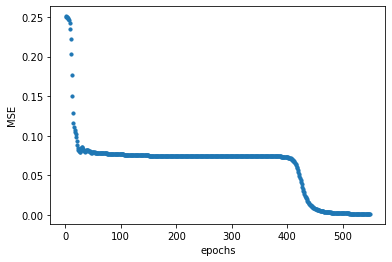

In [97]:
M_Model.plot_mse()

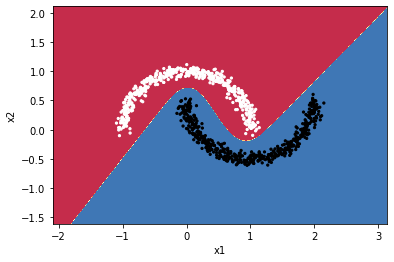

In [98]:
M_Model.plot_decision_boundary()